# MLP

Split data into Train , val, test

In [1]:
from typing import List

In [2]:
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [3]:
import torch.nn.functional as F

## 1. Data Gathering

In [4]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

## 2. Data Pre-Processing

In [6]:
START = END = '.'
CHARS = sorted(list(set(''.join(words))) + [START])

stoi = {char:idx for idx, char in enumerate(CHARS)}
itos = {i:s for s, i in stoi.items()}

In [7]:
print(f"\n{CHARS=}")
print(f"\n{stoi=}")
print(f"\n{itos=}")


CHARS=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

stoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

itos={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### 2.1 NGrams Split

In [8]:
def get_ngrams(words: List[str], ngrams=3, debug=False):
    X, Y = list(), list()
    
    for word in words:
        if debug: print(f"-- {word} --")
        context_idxs = [stoi[START]] * (ngrams-1)
        
        for char in word+END:
            pred_idx = stoi[char]
            Y.append(pred_idx)
            X.append(context_idxs)
            
            if debug: print(f"{''.join(itos[i] for i in context_idxs)} {itos[pred_idx]}")
            context_idxs = context_idxs[1:] + [pred_idx]
            
    return torch.tensor(X), torch.tensor(Y)

In [9]:
NGRAMS = 4
CONTEXT_SIZE = NGRAMS - 1

#### 2.1.1 Small Data

In [10]:
# TEST DATASET
X, Y = get_ngrams(words=words[:4], ngrams=NGRAMS, debug=True)

-- emma --
... e
..e m
.em m
emm a
mma .
-- olivia --
... o
..o l
.ol i
oli v
liv i
ivi a
via .
-- ava --
... a
..a v
.av a
ava .
-- isabella --
... i
..i s
.is a
isa b
sab e
abe l
bel l
ell a
lla .


#### 2.1.2 Train Test split

In [11]:
# Split to 80 : 10 : 10 :: Train : Val : Test

def split_data(data: List, ratio: float = 0.8):
    split_idx = int(ratio*len(data))
    return data[:split_idx], data[split_idx:]

split_data(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

([1, 2, 3, 4, 5, 6, 7, 8], [9, 0])

In [12]:
import random

# Shuffle words
random.shuffle(words)

In [13]:
train_words, test_words = split_data(data=words, ratio=0.8)
val_words, test_words = split_data(data=test_words, ratio=0.5)

len(train_words), len(val_words), len(test_words)

(25626, 3203, 3204)

In [14]:
# Complete Dataset

X_train, Y_train = get_ngrams(words=train_words, ngrams=NGRAMS, debug=False)
X_val, Y_val = get_ngrams(words=val_words, ngrams=NGRAMS, debug=False)
X_test, Y_test = get_ngrams(words=test_words, ngrams=NGRAMS, debug=False)


X_train.shape, Y_train.shape

(torch.Size([182561, 3]), torch.Size([182561]))

## 3. MLP

### 3.1 Architecture
From paper : [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

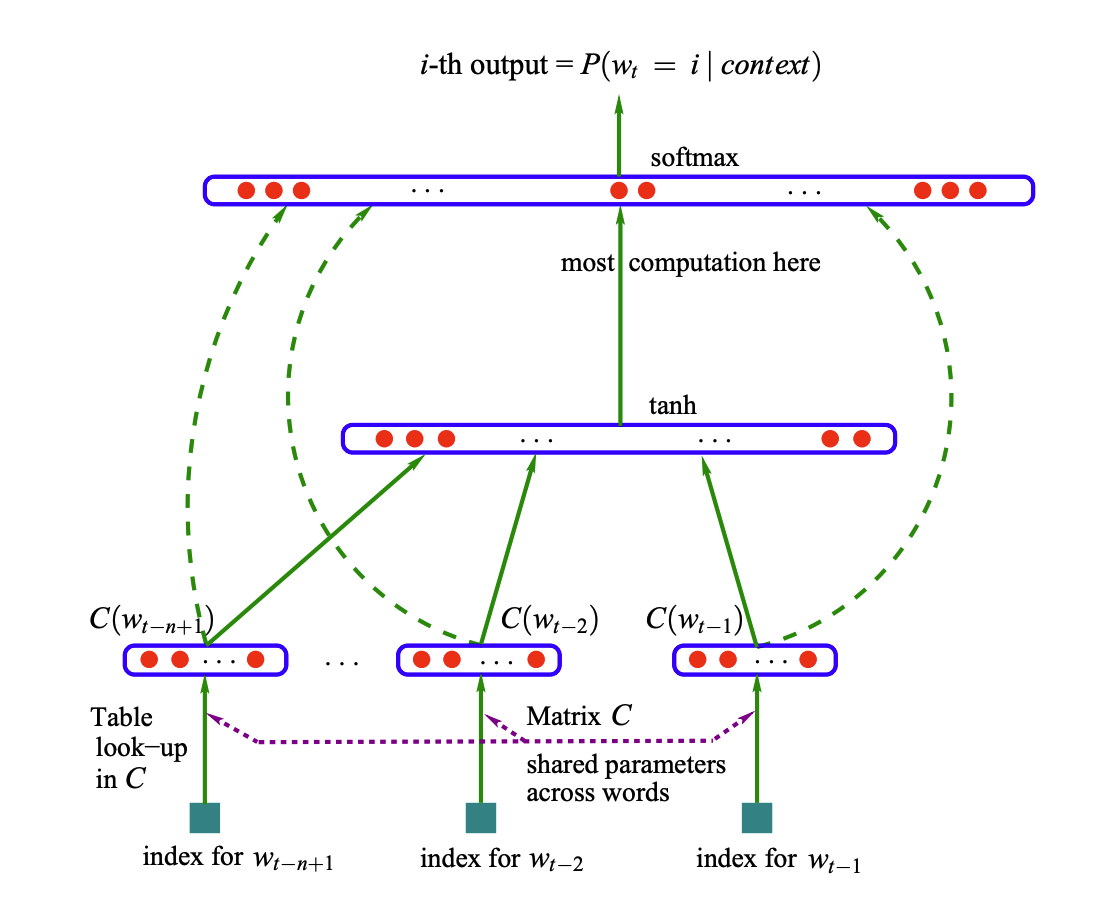

In [15]:
class MLP:
    
    def __init__(self, n_in, n_embed, n_positions, seed=4744):
        
        # Seed for reproducibility
        g = torch.Generator().manual_seed(seed)

        # Embeding Layer
        self.C = torch.randn((n_in, n_embed), generator=g)    

        # Hidden Layer
        self.W1 = torch.randn((CONTEXT_SIZE * n_embed, n_positions), generator=g)
        self.b1 = torch.randn((n_positions), generator=g)

        # Output Layer
        self.W2 = torch.randn((n_positions, n_in), generator=g)
        self.b2 = torch.randn((n_in), generator=g)

        # Parameters
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        print(f"Number of Model Params: {sum(p.nelement() for p in self.parameters)}")

        # Require Grads , for backprop
        for p in self.parameters: p.requires_grad = True
        
    def __call__(self, x):
        
        # Forward call
        emb = self.C[x]                                       # C(CHARS, N_EMBEDS) X[N, CONTEXT_SIZE] --> emb(N, CONTEXT_SIZE, N_EMBEDS)
        h = torch.tanh(emb.view(emb.shape[0], -1) @ self.W1 + self.b1)    # emb.view(N, CONTEXT_SIZE*N_EMBEDS) @ W1 + b1 --> (N, N_POSITIONS)
        logits = h @ self.W2 + self.b2                        # --> logits(N, CHARS)
        return logits
  

### 3.2 Training Loop

In [49]:
class Trainer:
    
    def __init__(self, model):
        self.model = model
        self.losses = list()
        self.epochs = 0
    
    @staticmethod
    def get_batch_idxs(x, batch_size):
        return torch.randint(0, x.shape[0], size=(batch_size,))
    
    def train(self, x, y, batch_size=32, epochs=10, lr=0.1):
        print(f"Dataset size: {len(x)}")
        epochs += self.epochs
        delta_epochs = epochs - self.epochs
        
        for epoch in tqdm(range(self.epochs, epochs), desc="Epochs"):
            # Batch indexes
            ix = self.get_batch_idxs(x, batch_size=batch_size)
            _x = x[ix]
            _y = y[ix]

            # Forward
            logits = self.model(_x)
            loss = F.cross_entropy(logits, _y)
            if epoch in {self.epochs} or epoch % int(delta_epochs/10) == int(delta_epochs/10) - 1: print(f"Loss {epoch+1}/{epochs}: {loss.item()}")
            self.losses.append(loss.item())

            # Backward
            for p in model.parameters: p.grad = None
            loss.backward()

            # Optimizer
            for p in model.parameters: p.data -= lr * p.grad
            
        self.epochs += delta_epochs
        return self.losses
    
    def evaluate(self, x, y):
        logits = self.model(x)
        loss = F.cross_entropy(logits, y)
        return loss

#### 3.6.1 Training

In [17]:
N_EMBED = 30
N_POSITIONS = 200

BATCH_SIZE = 32
EPOCHS = 1000
LR = 0.1

In [18]:
# INIT MODEL
model = MLP(n_in=len(CHARS), n_embed=N_EMBED, n_positions=N_POSITIONS)

Number of Model Params: 24437


In [50]:
trainer = Trainer(model=model)

In [51]:
trainer.losses = losses_
trainer.epochs = epochs_

Dataset size: 182561


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss 1/1000: 298.4914245605469
Loss 100/1000: 26.26935577392578
Loss 200/1000: 6.908295631408691
Loss 300/1000: 9.124261856079102
Loss 400/1000: 5.537518501281738
Loss 500/1000: 6.045088291168213
Loss 600/1000: 4.214343070983887
Loss 700/1000: 3.278378486633301
Loss 800/1000: 2.3813743591308594
Loss 900/1000: 3.7219460010528564
Loss 1000/1000: 3.9608852863311768


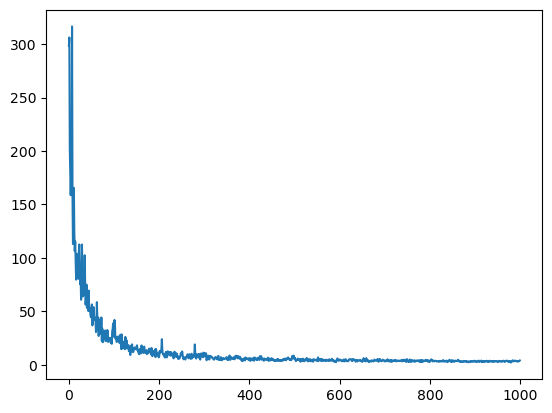

In [20]:
losses = trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=1000, lr=0.1)
plt.plot(losses)

In [21]:
# Train Loss
trainer.evaluate(x=X_train, y=Y_train)

tensor(4.6906, grad_fn=<NllLossBackward0>)

In [22]:
# Val Loss
trainer.evaluate(x=X_val, y=Y_val)

tensor(4.7150, grad_fn=<NllLossBackward0>)

#### 3.6.2 lr Decay

In [23]:
losses = trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=100, lr=0.05)

Dataset size: 182561


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Loss 1001/1100: 4.422813892364502
Loss 1010/1100: 3.0924675464630127
Loss 1020/1100: 2.5469624996185303
Loss 1030/1100: 2.636251926422119
Loss 1040/1100: 2.874751329421997
Loss 1050/1100: 2.555980920791626
Loss 1060/1100: 2.5327250957489014
Loss 1070/1100: 2.430744171142578
Loss 1080/1100: 2.762892723083496
Loss 1090/1100: 2.6220197677612305
Loss 1100/1100: 2.678799867630005


In [24]:
# Val Loss and Train Loss
print(f"Train Loss: {trainer.evaluate(x=X_train, y=Y_train)}")
print(f"Val Loss: {trainer.evaluate(x=X_val, y=Y_val)}")

Train Loss: 2.6102771759033203
Val Loss: 2.624007225036621


Dataset size: 182561


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Loss 1101/1200: 2.4188425540924072
Loss 1110/1200: 2.7994937896728516
Loss 1120/1200: 2.562861680984497
Loss 1130/1200: 2.436937093734741
Loss 1140/1200: 2.625044107437134
Loss 1150/1200: 2.331242561340332
Loss 1160/1200: 1.9558247327804565
Loss 1170/1200: 2.3713293075561523
Loss 1180/1200: 2.6130528450012207
Loss 1190/1200: 2.824861526489258
Loss 1200/1200: 2.853428363800049
Train Loss: 2.5308916568756104
Val Loss: 2.542940616607666


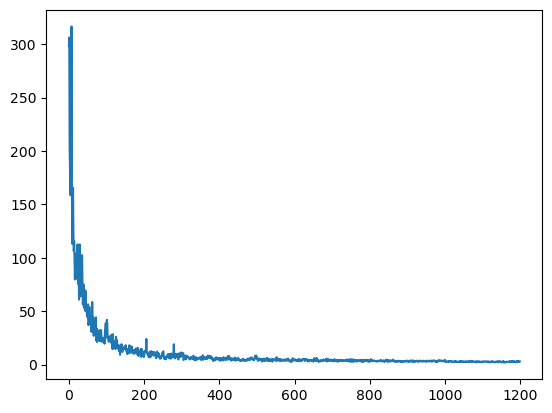

In [25]:
losses = trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=100, lr=0.05)
plt.plot(losses)
print(f"Train Loss: {trainer.evaluate(x=X_train, y=Y_train)}")
print(f"Val Loss: {trainer.evaluate(x=X_val, y=Y_val)}")

Dataset size: 182561


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Loss 1201/1300: 2.941441297531128
Loss 1210/1300: 2.3980488777160645
Loss 1220/1300: 2.257352590560913
Loss 1230/1300: 2.506587505340576
Loss 1240/1300: 2.385571002960205
Loss 1250/1300: 2.262796401977539
Loss 1260/1300: 2.7979464530944824
Loss 1270/1300: 3.0598015785217285
Loss 1280/1300: 2.572648286819458
Loss 1290/1300: 2.1079864501953125
Loss 1300/1300: 2.793548107147217
Train Loss: 2.4652223587036133
Val Loss: 2.4775171279907227


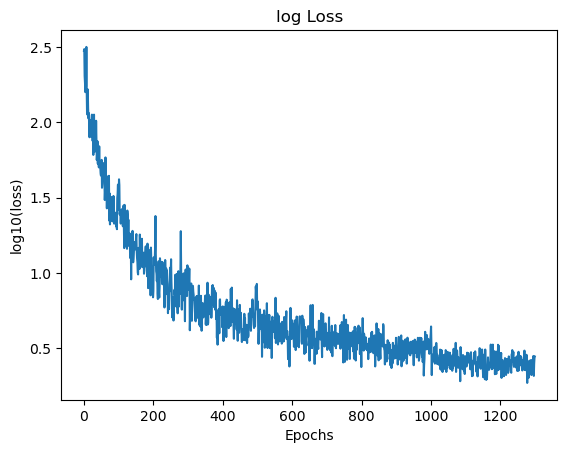

In [33]:
losses = trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=100, lr=0.001)
plt.plot(list(map(torch.log10, torch.tensor(losses)))); plt.title("log Loss"); plt.xlabel("Epochs"); plt.ylabel("log10(loss)")
print(f"Train Loss: {trainer.evaluate(x=X_train, y=Y_train)}")
print(f"Val Loss: {trainer.evaluate(x=X_val, y=Y_val)}")

Dataset size: 182561


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Loss 1301/1400: 2.476982593536377
Loss 1310/1400: 2.5270047187805176
Loss 1320/1400: 2.6051018238067627
Loss 1330/1400: 2.354375123977661
Loss 1340/1400: 2.3657116889953613
Loss 1350/1400: 2.368757486343384
Loss 1360/1400: 2.2147982120513916
Loss 1370/1400: 2.68121075630188
Loss 1380/1400: 2.4073212146759033
Loss 1390/1400: 2.590409755706787
Loss 1400/1400: 2.244347333908081
Train Loss: 2.438302755355835
Val Loss: 2.451047658920288


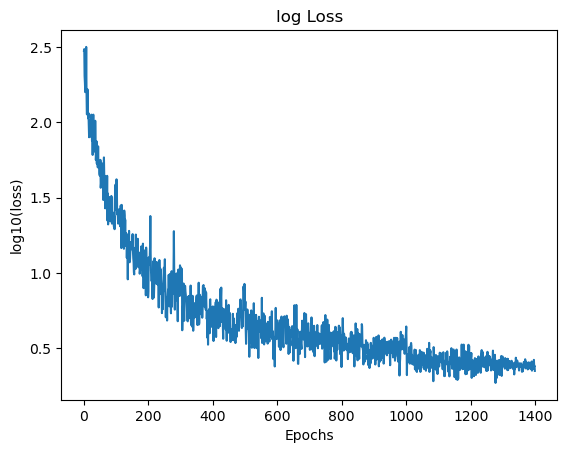

In [34]:
BATCH_SIZE = 128

losses = trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=100, lr=0.001)
plt.plot(list(map(torch.log10, torch.tensor(losses)))); plt.title("log Loss"); plt.xlabel("Epochs"); plt.ylabel("log10(loss)")
print(f"Train Loss: {trainer.evaluate(x=X_train, y=Y_train)}")
print(f"Val Loss: {trainer.evaluate(x=X_val, y=Y_val)}")

Dataset size: 182561


Epochs:   0%|          | 0/1300 [00:00<?, ?it/s]

Loss 1701/3000: 2.3504161834716797
Loss 1820/3000: 2.461080551147461
Loss 1950/3000: 2.204943895339966
Loss 2080/3000: 2.5209245681762695
Loss 2210/3000: 2.247081995010376
Loss 2340/3000: 2.4163196086883545
Loss 2470/3000: 2.5138704776763916
Loss 2600/3000: 2.3673994541168213
Loss 2730/3000: 2.5216245651245117
Loss 2860/3000: 2.3237667083740234
Loss 2990/3000: 2.3487319946289062
Train Loss: 2.3220627307891846
Val Loss: 2.3386709690093994


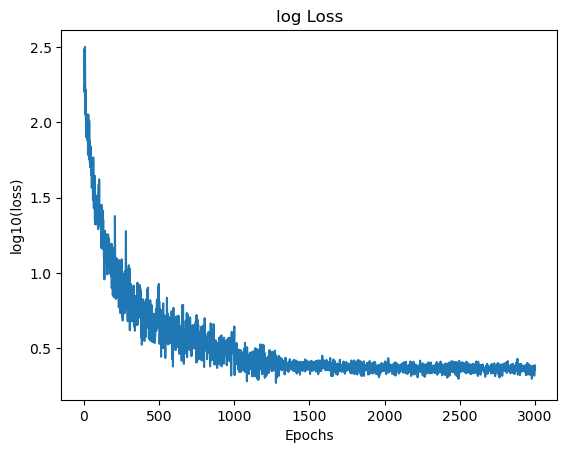

In [55]:
BATCH_SIZE = 128

losses = trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=1300, lr=0.01)
plt.plot(list(map(torch.log10, torch.tensor(losses)))); plt.title("log Loss"); plt.xlabel("Epochs"); plt.ylabel("log10(loss)")
print(f"Train Loss: {trainer.evaluate(x=X_train, y=Y_train)}")
print(f"Val Loss: {trainer.evaluate(x=X_val, y=Y_val)}")

In [57]:
print(f"Test Loss: {trainer.evaluate(x=X_test, y=Y_test)}")

Test Loss: 2.3196544647216797
